In [ ]:
%%html
<link href='https://fonts.googleapis.com/css?family=Roboto' rel='stylesheet'>
<style>
body {
    font-family: 'Roboto', 'Helvetica', sans-serif; 
    font-size: 16px;
}
</style>

<div style="background-color: #2b3237; padding-top: 20px;
  padding-right: 30px;
  padding-bottom: 10px;
  padding-left: 30px; width: 100%; display: flex">

<div style="background-color: #2b3237; padding-top: 20px;
  padding-right: 30px;
  padding-bottom: 20px;
  padding-left: 0px; width: 100%">

<font color=#ffffff size=6> <strong>Regional Voting Preferences in the 2016 Philippine Elections</strong> </font>
</div>
</div>

<div style="background-color: #e9e6e3; padding-top: 20px;
  padding-right: 15px;
  padding-bottom: 20px;
  padding-left: 30px">
<font color=#2b3237> <strong> George Allan Esleta (gesleta@aim.edu) </strong></font>
</div>

In [24]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import geopandas as gpd
from IPython.display import HTML

In [281]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

<div><span style="background-color: #2b3237; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #43a1e5; font-size: 20px; font-weight: bold">TASK </span></div>

1.	Create a denormalized table replacing `precinct_code` in the `results_*.csv` files with the columns: region, province, municipality, and barangay. 
2.	Create an interesting data visualization using this dataset.

<div><span style="background-color: #2b3237; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #43a1e5; font-size: 20px; font-weight: bold">DATA </span></div>

There are three (3) data sources, namely:

- `ref_table_precinct_locations_PSGC.csv` – lookup table for precincts
- `results_president.csv` – precinct-level election results for the 2016 presidential race
- `results_vice-president.csv` – precinct-level election results for the 2016 vice presidential race

To denormalize the election results data, each election result table will be joined with the precinct lookup table, with the `precinct_code` as the joining key.

The denormalization of the election results will be performed using the `pandas` library of Python and will proceed as follows:
1. <a id="#preprocessing">*Precinct Data preprocessing*</a>, which involves checking for duplicates and remapping of geographic names based on thir names in the geospatial shape file.
2. <a id="#preprocessing">*Election results preprocessing*</a>
3. <a id="#preprocessing">*Denormalization of election results*</a>, which involves joining the results table with the precinct table using the `precinct_code` as the joining key.

<div><span style="background-color: #2b3237; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #43a1e5; font-size: 20px; font-weight: bold">PRECINCT DATA PREPROCESSING </span></div>

The precinct lookup table is saved in a comma-separated value (CSV) file `ref_table_precinct_locations_PSGC.csv` and contains geographic information of each precinct such as region, province, municipality, and barangay. The contents of the file is read and loaded to a Pandas dataframe `df_precinct`:	 

In [148]:
df_precinct = pd.read_csv('Datasets/ref_table_precinct_locations_PSGC.csv', index_col='Unnamed: 0')

In [149]:
print(f'The dataframe has {df_precinct.shape[0]} rows and {df_precinct.shape[1]} columns')

The dataframe has 90642 rows and 14 columns


#### <font color="#43a1e5">Summary Statistics</font>

The file contains **90,642** precinct entries and 14 data fields. Infomation on the data columns such as count and data types are listed below:

In [150]:
df_precinct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90642 entries, 0 to 90641
Data columns (total 14 columns):
precinct_code        90642 non-null int64
region               90642 non-null object
province             90642 non-null object
municipality         90642 non-null object
barangay             90642 non-null object
registered_voters    90642 non-null int64
ballots_cast         90642 non-null int64
PSGC_CM              90642 non-null object
is_city              90642 non-null float64
income_class         90159 non-null object
population           58644 non-null float64
land_area            90159 non-null float64
province_CM          90642 non-null object
municipality_CM      90642 non-null object
dtypes: float64(3), int64(3), object(8)
memory usage: 10.4+ MB


#### <font color="#43a1e5">Data Description</font> 

The `df_precinct` lookup table has the following columns:

| Column | Data type | Description |
|---|---|---|
| `precinct_code`  | int | Unique identification number of the precinct |
|`region           ` | categorical | Administrative region where the precinct is located |
|`province         ` | categorical | Province where the precinct is located |
|`municipality     ` |object | Municipality/City where the precinct is located |
|`barangay         ` |object | Barangay where the precinct is located |
|`registered_voters` |int64  | Number of registered voters in the precinct |
|`ballots_cast     ` |int64  | Number of votes cast in the precinct |
|`PSGC_CM          ` |object | Philippine Standard Geographic Code (PSGC) for the city/municipality |
|`is_city          ` |boolean| True if the LGU is a city |
|`income_class     ` |object | Income class of the city/municipality |
|`population       ` |float64| Population of the city/municipality |
|`land_area        ` |float64| Land area of the city/municipality |
|`province_CM      ` |object | Name of the province in the PSGC database |
|`municipality_CM  ` |object | Name of the municipality/city in the PSGC database |

#### <font color="#43a1e5">Data Sample</font>

The first five entries in the precinct lookup data are shown below

In [151]:
df_precinct.head(5)

,precinct_code,region,province,municipality,barangay,registered_voters,ballots_cast,PSGC_CM,is_city,income_class,population,land_area,province_CM,municipality_CM
0,55170026,REGION I,PANGASINAN,CALASIAO,BUENLAG,592,503,15517000,0.0,1st,91109.0,4836.0,PANGASINAN,CALASIAO
1,55170027,REGION I,PANGASINAN,CALASIAO,BUENLAG,526,458,15517000,0.0,1st,91109.0,4836.0,PANGASINAN,CALASIAO
2,55170023,REGION I,PANGASINAN,CALASIAO,BUENLAG,723,649,15517000,0.0,1st,91109.0,4836.0,PANGASINAN,CALASIAO
3,55170022,REGION I,PANGASINAN,CALASIAO,BUENLAG,768,650,15517000,0.0,1st,91109.0,4836.0,PANGASINAN,CALASIAO
4,55170025,REGION I,PANGASINAN,CALASIAO,BUENLAG,787,662,15517000,0.0,1st,91109.0,4836.0,PANGASINAN,CALASIAO


#### <font color="#43a1e5">Checking for missing/ null values</font> 

The dataset is checked for missing or null values in any of its columns:

In [152]:
df_precinct.isnull().sum().to_frame(name='Number of null values')

,Number of null values
precinct_code,0
region,0
province,0
municipality,0
barangay,0
registered_voters,0
ballots_cast,0
PSGC_CM,0
is_city,0
income_class,483


Only `income_class`, `population`, and `land_area` have missing values. The precinct data has no missing/ null values for the `precinct_code` and the geographic columns (`region`, `province`, `municipality`, and `barangay`).

#### <font color="#43a1e5">Checking for uniqueness of `precinct_code`</font>

The `precinct_code` is the unique identifier of an election precinct; as such, there is a need to check for the uniqueness of this column. 

From the table below, the `precinct_code` has **90,642 distinct values**. This is equal to the row count of the dataframe, therefore confirming absence of duplicates.

In [153]:
df_precinct.nunique(axis=0, dropna=True).to_frame(name='Unique Values')

,Unique Values
precinct_code,90642
region,19
province,90
municipality,1454
barangay,26402
registered_voters,771
ballots_cast,793
PSGC_CM,1634
is_city,3
income_class,14


#### <font color="#43a1e5">Checking for unique values of `region`</font> 

There are **nineteen (19)** unique regions in the precinct lookup data:

In [154]:
print(f"There are {df_precinct['region'].nunique()} unique administrative regions.")

There are 19 unique administrative regions.


The unique values of the `region` column are displayed below. Note that ***Overseas Absentee Voters (OAV)*** is considered as a separate administrative region. Also, **Negros Island Region (NIR)**, which was dissolved in 2017, is still included in the database.

In [155]:
print(sorted(df_precinct['region'].unique()))

['ARMM', 'CAR', 'NCR', 'NIR', 'OAV', 'REGION I', 'REGION II', 'REGION III', 'REGION IV-A', 'REGION IV-B', 'REGION IX', 'REGION V', 'REGION VI', 'REGION VII', 'REGION VIII', 'REGION X', 'REGION XI', 'REGION XII', 'REGION XIII']


#### <font color="#43a1e5">Checking for unique values of `province` </font>

There are two (2) province-related columns: `province` and `province_CM`. To check if there are discrepancies between the two columns, we count the number of precinct entries where the `province_CM` column is not equal to the `province` column: 

In [156]:
df_precinct[df_precinct['province_CM'] != df_precinct['province']].shape

(0, 14)

There are no entries with unequal values for `province_cm` and `province`, confirming that two columns are identical and can be used interchangeably. For simplicity, the `province_CM` column will be used, as this is the official name of the province in the records of the Philippine Statistics Authority (PSA).

Listed below are the **ninety (90)** unique values for `province`.

In [157]:
print(sorted(df_precinct['province_CM'].unique()))

['ABRA', 'AGUSAN DEL NORTE', 'AGUSAN DEL SUR', 'AKLAN', 'ALBAY', 'ANTIQUE', 'APAYAO', 'ASIA', 'AURORA', 'BASILAN', 'BATAAN', 'BATANES', 'BATANGAS', 'BENGUET', 'BILIRAN', 'BOHOL', 'BUKIDNON', 'BULACAN', 'CAGAYAN', 'CAMARINES NORTE', 'CAMARINES SUR', 'CAMIGUIN', 'CAPIZ', 'CATANDUANES', 'CAVITE', 'CEBU', 'COMPOSTELA VALLEY', 'COTABATO (NORTH COT.)', 'DAVAO (DAVAO DEL NORTE)', 'DAVAO DEL SUR', 'DAVAO OCCIDENTAL', 'DAVAO ORIENTAL', 'DINAGAT ISLANDS', 'EASTERN SAMAR', 'EUROPE', 'GUIMARAS', 'IFUGAO', 'ILOCOS NORTE', 'ILOCOS SUR', 'ILOILO', 'ISABELA', 'KALINGA', 'LA UNION', 'LAGUNA', 'LANAO DEL NORTE', 'LANAO DEL SUR', 'LEYTE', 'MAGUINDANAO', 'MARINDUQUE', 'MASBATE', 'MIDDLE EAST AND AFRICAS', 'MISAMIS OCCIDENTAL', 'MISAMIS ORIENTAL', 'MOUNTAIN PROVINCE', 'NATIONAL CAPITAL REGION - FOURTH DISTRICT', 'NATIONAL CAPITAL REGION - MANILA', 'NATIONAL CAPITAL REGION - SECOND DISTRICT', 'NATIONAL CAPITAL REGION - THIRD DISTRICT', 'NEGROS OCCIDENTAL', 'NEGROS ORIENTAL', 'NORTH AND LATIN AMERICA', 'NORT

#### <font color="#43a1e5">Checking for unique values of `municipality` </font>

There are two (2) municipality-related columns: `municipality` and `municipality_CM`. To check if there are discrepancies between the two columns, we count the number of precinct entries where the `municipality_CM` column is not equal to the `municipality` column: 

In [158]:
df_precinct[df_precinct['municipality_CM'] != df_precinct['municipality']].shape

(1660, 14)

There are 1660 precinct entries with different `municipality_CM` and `municipality` values, samples of which are shown below: 

In [159]:
df_precinct[df_precinct['municipality_CM'] != df_precinct['municipality']].head()

,precinct_code,region,province,municipality,barangay,registered_voters,ballots_cast,PSGC_CM,is_city,income_class,population,land_area,province_CM,municipality_CM
80531,39121592,NCR,NATIONAL CAPITAL REGION - MANILA,PANDACAN,BARANGAY 856,768,624,133900000,1.0,1st Class-Special,NaN,2498.0,NATIONAL CAPITAL REGION - MANILA,MANILA
80532,39121576,NCR,NATIONAL CAPITAL REGION - MANILA,PANDACAN,BARANGAY 845,473,395,133900000,1.0,1st Class-Special,NaN,2498.0,NATIONAL CAPITAL REGION - MANILA,MANILA
80533,39121575,NCR,NATIONAL CAPITAL REGION - MANILA,PANDACAN,BARANGAY 845,579,461,133900000,1.0,1st Class-Special,NaN,2498.0,NATIONAL CAPITAL REGION - MANILA,MANILA
80534,39121590,NCR,NATIONAL CAPITAL REGION - MANILA,PANDACAN,BARANGAY 855,314,249,133900000,1.0,1st Class-Special,NaN,2498.0,NATIONAL CAPITAL REGION - MANILA,MANILA
80535,39121591,NCR,NATIONAL CAPITAL REGION - MANILA,PANDACAN,BARANGAY 855,475,397,133900000,1.0,1st Class-Special,NaN,2498.0,NATIONAL CAPITAL REGION - MANILA,MANILA


Upon quick inspection of the data, it appears that some entries have district name instead of the city name in the `municipality` column. Because of this, the `municipality_CM` column will be used moving forward.

#### <font color="#43a1e5"> Drop `province` and `municipality` columns </font> 

The `municipality` and `province` columns are dropped.

In [160]:
df_precinct.drop(['province', 'municipality'], axis=1, inplace=True)

#### <font color="#43a1e5"> Loading of shapefiles for geospatial visualization</font> 

The python package `geopandas` will be used to do geospatial visualization of the election data. Geopandas require shapefiles (`*.shp`), which are vector representations of the boundaries of geospatial entities such as countries, provinces, and cities.

Shapefiles for Philippine regions and provinces were obtained from [PhilGIS](http://philgis.org/country-basemaps/country-regions). Two (2) shapefiles were obtained: the region shapefile (`ph_regions.shp`) and the province shapefile (`ph_provinces.shp`)

The shapefiles are loaded to geopandas dataframes `ph_region` and `ph_province`.

In [161]:
ph_provinces = gpd.GeoDataFrame.from_file("Datasets\ph_provinces.shp")

In [162]:
ph_regions = gpd.GeoDataFrame.from_file("Datasets\ph_regions.shp")

A sample of the `ph_region` geodataframe entries are shown below:

In [163]:
ph_regions.head()

,region_num,region,geometry
0,0,ARMM,"MULTIPOLYGON (((119.46694 4.58694, 119.46639 4..."
1,1,REGION V,"MULTIPOLYGON (((122.98417 11.71056, 122.98333 ..."
2,2,REGION IV-A,"MULTIPOLYGON (((125.22166 10.43444, 125.22195 ..."
3,3,REGION II,"MULTIPOLYGON (((122.47040 16.91995, 122.47040 ..."
4,4,REGION XIII,"MULTIPOLYGON (((126.41750 7.96417, 126.41778 7..."


A sample of the `ph_province` geodataframe entries are shown below:

In [164]:
ph_provinces.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,NL_NAME_1,VARNAME_1,TYPE_1,ENGTYPE_1,province,REGION,geometry
0,177,PHL,Philippines,1,Abra,None,None,Lalawigan|Probinsya,Province,ABRA,Cordillera Administrative Region (CAR),"POLYGON ((120.96795 17.95706, 120.97803 17.949..."
1,177,PHL,Philippines,2,Agusan del Norte,None,None,Lalawigan|Probinsya,Province,AGUSAN DEL NORTE,Caraga (Region XIII),"POLYGON ((125.57724 9.45679, 125.59687 9.45509..."
2,177,PHL,Philippines,3,Agusan del Sur,None,None,Lalawigan|Probinsya,Province,AGUSAN DEL SUR,Caraga (Region XIII),"POLYGON ((125.91087 8.85625, 125.91461 8.85211..."
3,177,PHL,Philippines,4,Aklan,None,None,Lalawigan|Probinsya,Province,AKLAN,Western Visayas (Region VI),"MULTIPOLYGON (((122.43667 11.59833, 122.43667 ..."
4,177,PHL,Philippines,5,Albay,None,None,Lalawigan|Probinsya,Province,ALBAY,Bicol Region (Region V),"MULTIPOLYGON (((123.28764 13.04923, 123.28686 ..."


#### <font color="#43a1e5"> Re-mapping of precinct regions based on shape file labels</font>

To visualize the election data on a regional level, the `df_precinct` data will be joined with the `ph_regions` geodataframe using `region` as the joining column. Therefore, it is important that the values of `region` column of `df_precinct` has no discrepancies with the `region` column of `ph_regions`.

To check discrepancies between the two columns, the set of unique values for each column were obtained.

Getting the unique region values in the ``df_precinct` data:

In [165]:
regions_precinct = set(df_precinct['region'].unique())

In [166]:
print(regions_precinct)

{'REGION X', 'REGION II', 'REGION XII', 'REGION XI', 'REGION IV-A', 'REGION VI', 'OAV', 'REGION V', 'REGION XIII', 'REGION I', 'REGION VII', 'REGION IV-B', 'REGION III', 'ARMM', 'REGION VIII', 'CAR', 'REGION IX', 'NCR', 'NIR'}


Getting the unique region values in the `ph_region` shapefile:

In [167]:
regions_shape = set(ph_regions['region'].unique())

In [168]:
print(regions_shape)

{'REGION VIII', 'REGION II', 'REGION X', 'REGION XIII', 'REGION VII', 'CAR', 'REGION I', 'REGION IV-A', 'REGION VI', 'REGION V', 'REGION IV-B', 'REGION IX', 'REGION XI', 'REGION III', 'REGION XII', 'ARMM', 'NCR'}


After getting the set of unique values, the difference of the two sets are obtained.

In [169]:
regions_precinct.difference(regions_shape)

{'NIR', 'OAV'}

In [170]:
regions_shape.difference(regions_precinct)

set()

'NIR' (Negros Island Region) and 'OAV' (Overseas Absentee Voting) are not in the shape file. To address this, precinct entries with 'NEGROS OCCIDENTAL' as province will be reassigned to `region = 'REGION VI'`, while precinct entries with 'NEGROS ORIENTAL' as province will be transferred to `region = 'REGION VII'`  

In [171]:
def replace_region(x):
    """
    Special handling for Negros Occidental and Negros Oriental
    """
    if x['province_CM'] == 'NEGROS OCCIDENTAL':
        return 'REGION VI'
    elif x['province_CM'] == 'NEGROS ORIENTAL':
        return 'REGION VII'
    else:
        return x['region']

In [172]:
df_precinct['region'] = df_precinct.apply(lambda x: replace_region(x), axis=1)

Rechecking the two columns:

In [173]:
regions_precinct = set(df_precinct['region'].unique())

In [174]:
regions_precinct.difference(regions_shape)

{'OAV'}

In [175]:
regions_shape.difference(regions_precinct)

set()

After remapping of the regions, only the OAV data is missing from the shapefile.

#### <font color="#43a1e5"> Re-mapping of provinces based on shapefile labels </font> 

To visualize the election data on a provincial level, the `df_precinct` data will be joined with the `ph_provinces` geodataframe, using `province` as the joining column. Therefore, it is important that the values of `province` column of `df_precinct` has no discrepancies with the `province` column of `ph_provinces`.

To check discrepancies between the two columns, the set of unique values for each column were obtained.

Getting the unique province values in the `df_precinct` data:

In [176]:
provinces_precinct = set(df_precinct['province_CM'].unique())

In [177]:
print(provinces_precinct)

{'EASTERN SAMAR', 'SIQUIJOR', 'MARINDUQUE', 'OCCIDENTAL MINDORO', 'ILOILO', 'ROMBLON', 'BOHOL', 'ZAMBALES', 'DAVAO DEL SUR', 'NUEVA VIZCAYA', 'AGUSAN DEL SUR', 'NEGROS OCCIDENTAL', 'ANTIQUE', 'SOUTH COTABATO', 'LAGUNA', 'GUIMARAS', 'IFUGAO', 'ILOCOS SUR', 'SULTAN KUDARAT', 'CAVITE', 'NATIONAL CAPITAL REGION - SECOND DISTRICT', 'COTABATO (NORTH COT.)', 'TAGUIG - PATEROS', 'LA UNION', 'RIZAL', 'ALBAY', 'TARLAC', 'BENGUET', 'BILIRAN', 'BUKIDNON', 'NATIONAL CAPITAL REGION - MANILA', 'LANAO DEL NORTE', 'NORTHERN SAMAR', 'AKLAN', 'DAVAO (DAVAO DEL NORTE)', 'ASIA', 'PALAWAN', 'SULU', 'TAWI-TAWI', 'MISAMIS ORIENTAL', 'MISAMIS OCCIDENTAL', 'ORIENTAL MINDORO', 'CAPIZ', 'SORSOGON', 'ISABELA', 'CAMIGUIN', 'CAMARINES SUR', 'ZAMBOANGA SIBUGAY', 'BATANES', 'ABRA', 'SAMAR (WESTERN SAMAR)', 'DAVAO ORIENTAL', 'CEBU', 'LEYTE', 'AURORA', 'MIDDLE EAST AND AFRICAS', 'AGUSAN DEL NORTE', 'MOUNTAIN PROVINCE', 'QUIRINO', 'NUEVA ECIJA', 'KALINGA', 'BATANGAS', 'CAMARINES NORTE', 'NATIONAL CAPITAL REGION - THIRD D

Getting the unique province values in the ``ph_province` shape file:

In [178]:
provinces_shape = set(ph_provinces['province'].unique())

After getting the set of unique values, the difference of the two sets are obtained.

In [179]:
provinces_precinct.difference(provinces_shape)

{'ASIA',
 'COTABATO (NORTH COT.)',
 'DAVAO (DAVAO DEL NORTE)',
 'DAVAO OCCIDENTAL',
 'EUROPE',
 'MIDDLE EAST AND AFRICAS',
 'NATIONAL CAPITAL REGION - FOURTH DISTRICT',
 'NATIONAL CAPITAL REGION - MANILA',
 'NATIONAL CAPITAL REGION - SECOND DISTRICT',
 'NATIONAL CAPITAL REGION - THIRD DISTRICT',
 'NORTH AND LATIN AMERICA',
 'SAMAR (WESTERN SAMAR)',
 'TAGUIG - PATEROS'}

In [180]:
provinces_shape.difference(provinces_precinct)

{'DAVAO DEL NORTE',
 'METROPOLITAN MANILA',
 'NORTH COTABATO',
 'SAMAR',
 'SHARIFF KABUNSUAN'}

A mapping was created to reconcile the differences in the province names in the precinct lookup file and the province shape file. Province names in the precinct file were replaced with their corresponding names in the shape file:

In [282]:
print(mapping_province)

{'NATIONAL CAPITAL REGION - FOURTH DISTRICT': 'METROPOLITAN MANILA', 'DAVAO OCCIDENTAL': 'DAVAO DEL SUR', 'NATIONAL CAPITAL REGION - MANILA': 'METROPOLITAN MANILA', 'NATIONAL CAPITAL REGION - SECOND DISTRICT': 'METROPOLITAN MANILA', 'NATIONAL CAPITAL REGION - THIRD DISTRICT': 'METROPOLITAN MANILA', 'COTABATO (NORTH COT.)': 'NORTH COTABATO', 'DAVAO (DAVAO DEL NORTE)': 'DAVAO DEL NORTE', 'SAMAR (WESTERN SAMAR)': 'SAMAR', 'TAGUIG - PATEROS': 'METROPOLITAN MANILA'}


In [181]:
mapping_province = {'NATIONAL CAPITAL REGION - FOURTH DISTRICT': 'METROPOLITAN MANILA',
                    'DAVAO OCCIDENTAL': 'DAVAO DEL SUR',
                    'NATIONAL CAPITAL REGION - MANILA': 'METROPOLITAN MANILA',
                    'NATIONAL CAPITAL REGION - SECOND DISTRICT': 'METROPOLITAN MANILA',
                    'NATIONAL CAPITAL REGION - THIRD DISTRICT': 'METROPOLITAN MANILA',
                    'COTABATO (NORTH COT.)': 'NORTH COTABATO',
                    'DAVAO (DAVAO DEL NORTE)': 'DAVAO DEL NORTE',
                    'SAMAR (WESTERN SAMAR)': 'SAMAR',
                    'TAGUIG - PATEROS': 'METROPOLITAN MANILA'}

In [182]:
df_precinct['province'] = df_precinct['province_CM'].replace(mapping_province)

Rechecking for consistency of the two columns:

In [183]:
provinces_precinct = set(df_precinct['province'].unique())

In [184]:
provinces_shape.difference(provinces_precinct)

{'SHARIFF KABUNSUAN'}

In [185]:
provinces_precinct.difference(provinces_shape)

{'ASIA', 'EUROPE', 'MIDDLE EAST AND AFRICAS', 'NORTH AND LATIN AMERICA'}

After remapping, only the OAV regions were not in the shape file.

`province_CM` is dropped from the precinct data, as this is redundant with `province`:

In [186]:
df_precinct.drop(['province_CM'], axis=1, inplace=True)

#### <font color="#43a1e5"> Renaming of columns </font> 

The `municipality_CM` is renamed to `municipality` to standardize the gographic column names:

In [187]:
df_precinct.rename(columns={'municipality_CM': 'municipality'}, inplace=True)

In [188]:
cols = ['precinct_code', 'region', 'province', 'municipality', 'barangay']

In [189]:
df_precinct

,precinct_code,region,barangay,registered_voters,ballots_cast,PSGC_CM,is_city,income_class,population,land_area,municipality,province
0,55170026,REGION I,BUENLAG,592,503,15517000,0.0,1st,91109.0,4836.0,CALASIAO,PANGASINAN
1,55170027,REGION I,BUENLAG,526,458,15517000,0.0,1st,91109.0,4836.0,CALASIAO,PANGASINAN
2,55170023,REGION I,BUENLAG,723,649,15517000,0.0,1st,91109.0,4836.0,CALASIAO,PANGASINAN
3,55170022,REGION I,BUENLAG,768,650,15517000,0.0,1st,91109.0,4836.0,CALASIAO,PANGASINAN
4,55170025,REGION I,BUENLAG,787,662,15517000,0.0,1st,91109.0,4836.0,CALASIAO,PANGASINAN
5,55170024,REGION I,BUENLAG,746,647,15517000,0.0,1st,91109.0,4836.0,CALASIAO,PANGASINAN
6,55170002,REGION I,POBLACION EAST,600,531,15517000,0.0,1st,91109.0,4836.0,CALASIAO,PANGASINAN
7,55170001,REGION I,POBLACION EAST,520,471,15517000,0.0,1st,91109.0,4836.0,CALASIAO,PANGASINAN
8,55170056,REGION I,MANCUP,750,650,15517000,0.0,1st,91109.0,4836.0,CALASIAO,PANGASINAN
9,55170057,REGION I,MANCUP,692,614,15517000,0.0,1st,91109.0,4836.0,CALASIAO,PANGASINAN


#### <font color="#43a1e5"> Load to Pickle </font> 

The preprocessed precinct date is dumped to a pickle file.

In [190]:
with open('Datasets/precinct_clean.pkl', 'wb') as f:
    pickle.dump(df_precinct, f)

<div><span style="background-color: #2b3237; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #43a1e5; font-size: 20px; font-weight: bold">PRESIDENT DATA </span></div>

The presidential election results are stored in a CSV file (`results_president.csv`). The data is loaded to a Pandas dataframe `df_president`:

In [191]:
df_president = pd.read_csv('Datasets/results_president.csv') 

In [192]:
print(f'The dataframe has {df_president.shape[0]} rows and {df_president.shape[1]} columns')

The dataframe has 542154 rows and 11 columns


#### <font color="#43a1e5">Summary Statistics</font>

The file contains **542,154** precinct-level election result entries and 11 data columns. Infomation on the data columns such as count and data types are listed below:

In [193]:
df_president.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542154 entries, 0 to 542153
Data columns (total 11 columns):
precinct_code     542154 non-null int64
contest_code      542154 non-null int64
candidate_name    542154 non-null object
party_code        542154 non-null int64
votes             542154 non-null int64
col5              542154 non-null int64
ballots_cast      542154 non-null int64
col7              542154 non-null int64
col8              542154 non-null int64
timestamp         542154 non-null object
pct_votes         540972 non-null float64
dtypes: float64(1), int64(8), object(2)
memory usage: 45.5+ MB


#### <font color="#43a1e5">Data Description</font> 

The `df_president` lookup table has the following columns:

| Column | Data type | Description |
|---|---|---|
|precinct_code    | int64|  Precinct code | 
|contest_code     | int64|  Contest code | 
|candidate_name   | object| Name of the presidential candidate |  
|party_code       | int64|  Party code | 
|votes            | int64|  Number of votes obtained by the candidate in the precinct | 
|col5             | int64|  | 
|ballots_cast     | int64|  Number of ballots cast in the precinct| 
|col7             | int64|  | 
|col8             | int64|  | 
|timestamp        | object| Timestamp|  
|pct_votes        | float|  | 

#### <font color="#43a1e5">Data Sample</font>

The first five entries in the presidential election results data are shown below

In [194]:
df_president.head(5)

,precinct_code,contest_code,candidate_name,party_code,votes,col5,ballots_cast,col7,col8,timestamp,pct_votes
0,69140005,199009,"DUTERTE, RODY (PDPLBN)",114,124,3,639,13,8,05/09/2016 17:05:50,0.194053
1,69140005,199009,"DEFENSOR SANTIAGO, MIRIAM (PRP)",135,12,2,639,13,8,05/09/2016 17:05:50,0.018779
2,69140005,199009,"BINAY, JOJO (UNA)",163,94,1,639,13,8,05/09/2016 17:05:50,0.147105
3,69140005,199009,"ROXAS, MAR DAANG MATUWID (LP)",85,126,5,639,13,8,05/09/2016 17:05:50,0.197183
4,69140005,199009,"SEÑERES, ROY (WPPPMM)",165,1,6,639,13,8,05/09/2016 17:05:50,0.001565


#### <font color="#43a1e5">Checking for missing/ null values</font> 

The dataset is checked for missing or null values in any of its columns:

In [195]:
df_president.isnull().sum().to_frame(name='Number of null values')

,Number of null values
precinct_code,0
contest_code,0
candidate_name,0
party_code,0
votes,0
col5,0
ballots_cast,0
col7,0
col8,0
timestamp,0


Only `pct_votes` have missing values. 

#### <font color="#43a1e5">Checking for unique values of `candidate_name`</font> 

In [197]:
df_president.nunique(axis=0, dropna=True).to_frame(name='Unique Values')

,Unique Values
precinct_code,90359
contest_code,1
candidate_name,6
party_code,6
votes,769
col5,6
ballots_cast,785
col7,210
col8,86
timestamp,29587


There are **six (6)** unique candidate names in the data:

In [199]:
print(f"There are {df_president['candidate_name'].nunique()} presidential candidates.")

There are 6 presidential candidates.


The unique values of the `candidate_name` column are displayed below:

In [201]:
print(sorted(df_president['candidate_name'].unique()))

['BINAY, JOJO (UNA)', 'DEFENSOR SANTIAGO, MIRIAM (PRP)', 'DUTERTE, RODY (PDPLBN)', 'POE, GRACE (IND)', 'ROXAS, MAR DAANG MATUWID (LP)', 'SEÑERES, ROY (WPPPMM)']


<div><span style="background-color: #2b3237; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #43a1e5; font-size: 20px; font-weight: bold">DENORMALIZATION OF PRESIDENTIAL RESULTS DATA </span></div>

To denormalize the presidential results, the `df_president` table is joined with the `df_precinct` table using `precinct_code` as the joining key. A left merge is done to ensure that all election results are included in the final denormalized table:

In [204]:
df_pres_merged = pd.merge(df_president, 
                          df_precinct[['precinct_code', 'region', 'province', 'municipality', 'barangay']], 
                          on='precinct_code', how='left')

The resulting denormalized table must have the same number of rows as the original elections table:

In [205]:
df_pres_merged.shape

(542154, 15)

Upon checking, there are 60 rows with missing geographic data. These are election entries whose precinct codes are not found in the precinct in the lookup file

In [206]:
df_pres_merged.isnull().sum()

precinct_code        0
contest_code         0
candidate_name       0
party_code           0
votes                0
col5                 0
ballots_cast         0
col7                 0
col8                 0
timestamp            0
pct_votes         1182
region              60
province            60
municipality        60
barangay            60
dtype: int64

The `precinct_code` column is dropped:

In [214]:
df_pres_merged.drop(['precinct_code'], axis=1, inplace=True)

The denormalized presidential results data containing geographic data (region, province, municipality, barangay) is saved into a new csv file `results_president_denormalized.csv`:

In [215]:
with open('Datasets/results_president_denormalized.pkl', 'wb') as f:
    pickle.dump(df_pres_merged, f)

In [216]:
df_pres_merged.to_csv(r'Datasets/results_president_denormalized.csv')

<div><span style="background-color: #2b3237; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #43a1e5; font-size: 20px; font-weight: bold">VICE-PRESIDENT DATA </span></div>

The vice presidential election results are stored in a CSV file (`results_vice-president.csv`). The data is loaded to a Pandas dataframe `df_vp`:

In [217]:
df_vp = pd.read_csv('Datasets/results_vice-president.csv') 

In [218]:
print(f'The dataframe has {df_vp.shape[0]} rows and {df_vp.shape[1]} columns')

The dataframe has 542160 rows and 11 columns


#### <font color="#43a1e5">Summary Statistics</font>

The file contains **542,160** precinct-level election result entries and 11 data columns. Infomation on the data columns such as count and data types are listed below:

In [220]:
df_vp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542160 entries, 0 to 542159
Data columns (total 11 columns):
precinct_code     542160 non-null int64
contest_code      542160 non-null int64
candidate_name    542160 non-null object
party_code        542160 non-null int64
votes             542160 non-null int64
col5              542160 non-null int64
ballots_cast      542160 non-null int64
col7              542160 non-null int64
col8              542160 non-null int64
timestamp         542160 non-null object
pct_votes         540978 non-null float64
dtypes: float64(1), int64(8), object(2)
memory usage: 45.5+ MB


#### <font color="#43a1e5">Data Description</font> 

The `df_vp` lookup table has the same columns as the `df_president` table:

| Column | Data type | Description |
|---|---|---|
|precinct_code    | int64|  Precinct code | 
|contest_code     | int64|  Contest code | 
|candidate_name   | object| Name of the presidential candidate |  
|party_code       | int64|  Party code | 
|votes            | int64|  Number of votes obtained by the candidate in the precinct | 
|col5             | int64|  | 
|ballots_cast     | int64|  Number of ballots cast in the precinct| 
|col7             | int64|  | 
|col8             | int64|  | 
|timestamp        | object| Timestamp|  
|pct_votes        | float|  | 

#### <font color="#43a1e5">Data Sample</font>

The first five entries in the vice-president results data are shown below

In [221]:
df_vp.head(5)

,precinct_code,contest_code,candidate_name,party_code,votes,col5,ballots_cast,col7,col8,timestamp,pct_votes
0,10030074,299009,"ROBREDO, LENI DAANG MATUWID (LP)",85,185,5,535,25,9,05/09/2016 17:07:51,0.345794
1,10030074,299009,"ESCUDERO, CHIZ (IND)",58,133,2,535,25,9,05/09/2016 17:07:51,0.248598
2,10030074,299009,"CAYETANO, ALAN PETER (IND)",58,36,1,535,25,9,05/09/2016 17:07:51,0.067290
3,1070001,299009,"MARCOS, BONGBONG (IND)",58,498,4,558,15,2,05/09/2016 17:07:53,0.892473
4,36320001,299009,"MARCOS, BONGBONG (IND)",58,368,4,442,19,1,05/09/2016 17:05:50,0.832579


#### <font color="#43a1e5">Checking for missing/ null values</font> 

The dataset is checked for missing or null values in any of its columns:

In [222]:
df_vp.isnull().sum().to_frame(name='Number of null values')

,Number of null values
precinct_code,0
contest_code,0
candidate_name,0
party_code,0
votes,0
col5,0
ballots_cast,0
col7,0
col8,0
timestamp,0


Only `pct_votes` have missing values. 

#### <font color="#43a1e5">Checking for unique values of `candidate_name`</font> 

In [223]:
df_vp.nunique(axis=0, dropna=True).to_frame(name='Unique Values')

,Unique Values
precinct_code,90360
contest_code,1
candidate_name,6
party_code,3
votes,686
col5,6
ballots_cast,785
col7,326
col8,57
timestamp,29600


There are **six (6)** unique candidate names in the data:

In [225]:
print(f"There are {df_vp['candidate_name'].nunique()} vice presidential candidates.")

There are 6 vice presidential candidates.


The unique values of the `candidate_name` column are displayed below:

In [224]:
print(sorted(df_vp['candidate_name'].unique()))

['CAYETANO, ALAN PETER (IND)', 'ESCUDERO, CHIZ (IND)', 'HONASAN, GRINGO (UNA)', 'MARCOS, BONGBONG (IND)', 'ROBREDO, LENI DAANG MATUWID (LP)', 'TRILLANES, ANTONIO IV (IND)']


<div><span style="background-color: #2b3237; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #43a1e5; font-size: 20px; font-weight: bold">DENORMALIZATION OF VICE-PRESIDENTIAL RESULTS DATA </span></div>

To denormalize the vice-presidential results, the `df_vp` table is joined with the `df_precinct` table using `precinct_code` as the joining key. A left merge is done to ensure that all election results are included in the final denormalized table:

In [226]:
df_vp_merged = pd.merge(df_vp, 
                          df_precinct[['precinct_code', 'region', 'province', 'municipality', 'barangay']], 
                          on='precinct_code', how='left')

The resulting denormalized table must have the same number of rows as the original elections table:

In [227]:
df_vp_merged.shape

(542160, 15)

Upon checking, there are 60 rows with missing geographic data. These are election entries whose precinct codes are not found in the precinct in the lookup file

In [228]:
df_vp_merged.isnull().sum()

precinct_code        0
contest_code         0
candidate_name       0
party_code           0
votes                0
col5                 0
ballots_cast         0
col7                 0
col8                 0
timestamp            0
pct_votes         1182
region              60
province            60
municipality        60
barangay            60
dtype: int64

The `precinct_code` column is dropped:

In [229]:
df_vp_merged.drop(['precinct_code'], axis=1, inplace=True)

The denormalized vice-presidential results data containing geographic data (region, province, municipality, barangay) is saved into a new csv file `results_vice-president_denormalized.csv`:

In [230]:
with open('Datasets/results_vice-president_denormalized.pkl', 'wb') as f:
    pickle.dump(df_vp_merged, f)

In [231]:
df_vp_merged.to_csv(r'Datasets/results_vice-president_denormalized.csv')

In [ ]:
df_vp_merged.to_csv(r'Datasets/results_vice-president_denormalized.csv')

<div><span style="background-color: #2b3237; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #43a1e5; font-size: 20px; font-weight: bold">EXPLORATORY DATA ANALYSIS </span></div>

The denormalized presidential and vice-presidential election results are explored below.

In [232]:
with open('Datasets/results_president_denormalized.pkl', 'rb') as f:
    df_pres = pickle.load(f)

In [233]:
with open('Datasets/results_vice-president_denormalized.pkl', 'rb') as f:
    df_vp = pickle.load(f)

#### <font color="#43a1e5">Total votes</font> 

In [237]:
print(f"There are {df_pres['votes'].sum()} total votes for the presidential contest")

There are 41278124 total votes for the presidential contest


In [238]:
print(f"There are {df_vp['votes'].sum()} total votes for the vice presidential contest")

There are 39832254 total votes for the vice presidential contest


#### <font color="#43a1e5">Total votes per candidate</font> 

**Rodrigo Duterte** led the presidential race with 15.9 million votes.

In [242]:
df_pres.groupby('candidate_name')['votes'].agg(sum).sort_values(ascending=False).to_frame()

,votes
candidate_name,
"DUTERTE, RODY (PDPLBN)",15911228
"ROXAS, MAR DAANG MATUWID (LP)",9678767
"POE, GRACE (IND)",8929294
"BINAY, JOJO (UNA)",5313232
"DEFENSOR SANTIAGO, MIRIAM (PRP)",1420490
"SEÑERES, ROY (WPPPMM)",25113


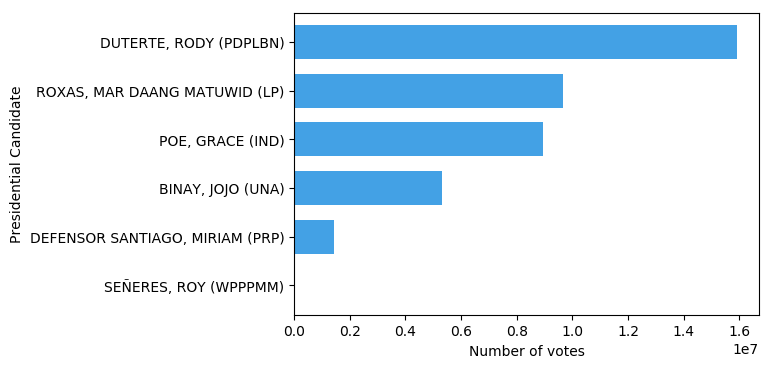

In [254]:
fig, ax = plt.subplots(dpi=100)
df_pres.groupby('candidate_name')['votes'].agg(sum).sort_values(ascending=True).plot(kind='barh', color='#43a1e5', ax=ax, width=0.7)
ax.set_ylabel('Presidential Candidate')
ax.set_xlabel('Number of votes');

#### Figure 1. Total votes obtained by each presidential candidate.

**Leni Robredo** led the presidential race with 14.0 million votes.

In [243]:
df_vp.groupby('candidate_name')['votes'].agg(sum).sort_values(ascending=False).to_frame()

,votes
candidate_name,
"ROBREDO, LENI DAANG MATUWID (LP)",13988939
"MARCOS, BONGBONG (IND)",13774268
"CAYETANO, ALAN PETER (IND)",5661737
"ESCUDERO, CHIZ (IND)",4806654
"TRILLANES, ANTONIO IV (IND)",842391
"HONASAN, GRINGO (UNA)",758265


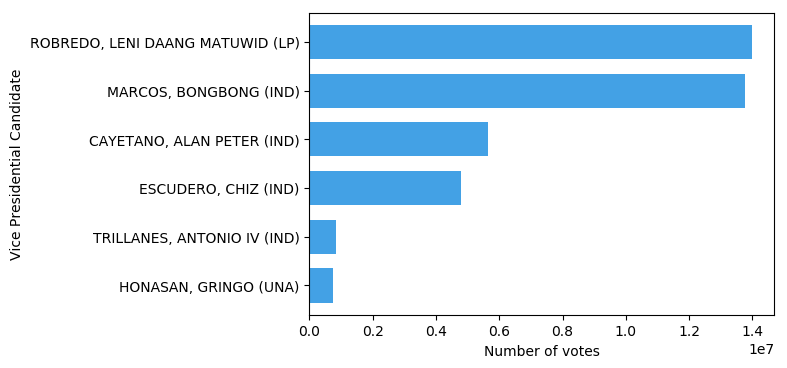

In [253]:
fig, ax = plt.subplots(dpi=100)
df_vp.groupby('candidate_name')['votes'].agg(sum).sort_values(ascending=True).plot(kind='barh', color='#43a1e5', ax=ax, width=0.7)
ax.set_ylabel('Vice Presidential Candidate')
ax.set_xlabel('Number of votes');

#### Figure 2. Total votes obtained by each vice-presidential candidate.

#### <font color="#43a1e5">Total votes per region</font> 

From the figure below, CALABARZON, Central Luzon, and NCR are the most voter-rich regions.

In [250]:
def plot_dist_level(level='region'):
    """
    Plots distribution of votes by the specified geographic level
    
    level : region/province
    """
    fig, ax = plt.subplots(1, 2, dpi=150, figsize=(12,5))
    fig.tight_layout(pad=6.0)
    df_pres.groupby(level)['votes'].agg(sum).sort_values(ascending=True)[-20:].plot(kind='barh', color='#43a1e5', ax=ax[0], width=0.7)
    ax[0].set_ylabel(level)
    ax[0].set_xlabel('Number of president votes')
    df_vp.groupby(level)['votes'].agg(sum).sort_values(ascending=True)[-20:].plot(kind='barh', color='#43a1e5', ax=ax[1], width=0.7)
    ax[1].set_ylabel(level)
    ax[1].set_xlabel('Number of vice president votes');
    

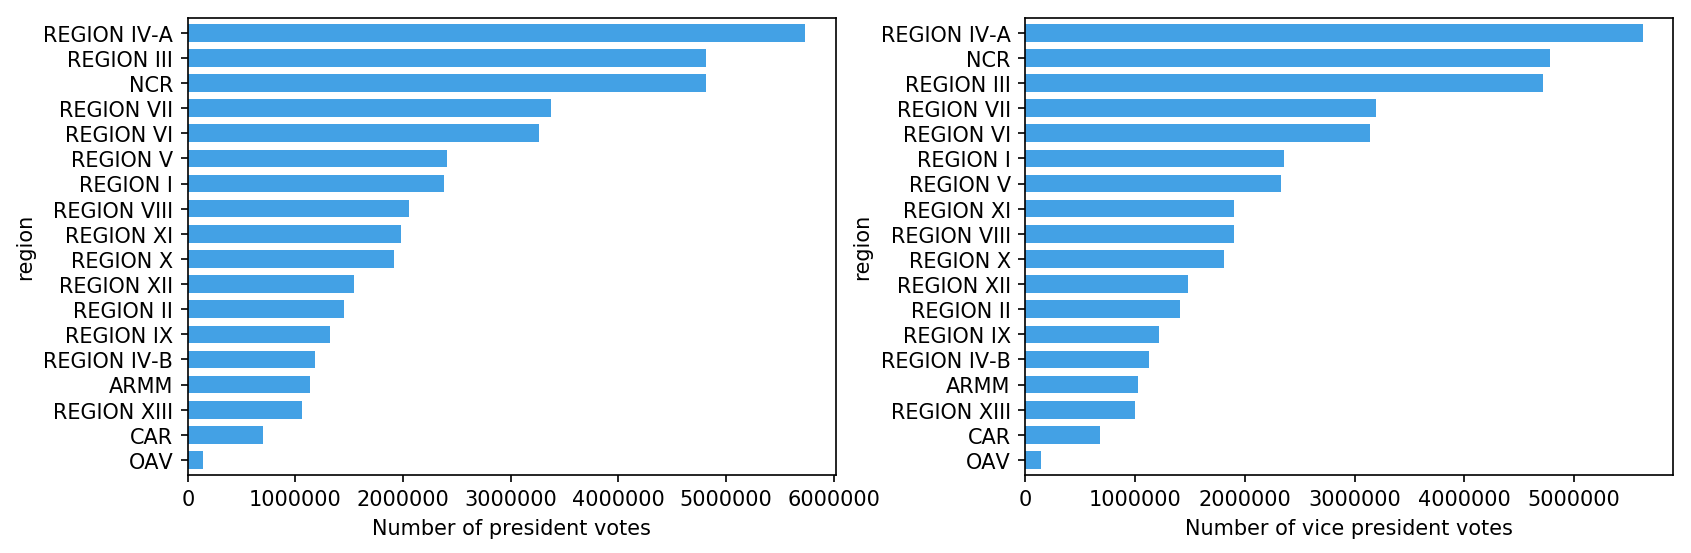

In [251]:
plot_dist_level(level='region')

#### Figure 3. Total presidential and vice-presidential votes obtained per administrative region. CALABARZON, Central Luzon, and NCR are the most vote-rich regions.

#### <font color="#43a1e5">Total votes per province</font> 

From the figure below, the most vote-rich provinces are NCR, Cebu, Cavite, and Pangasinan.

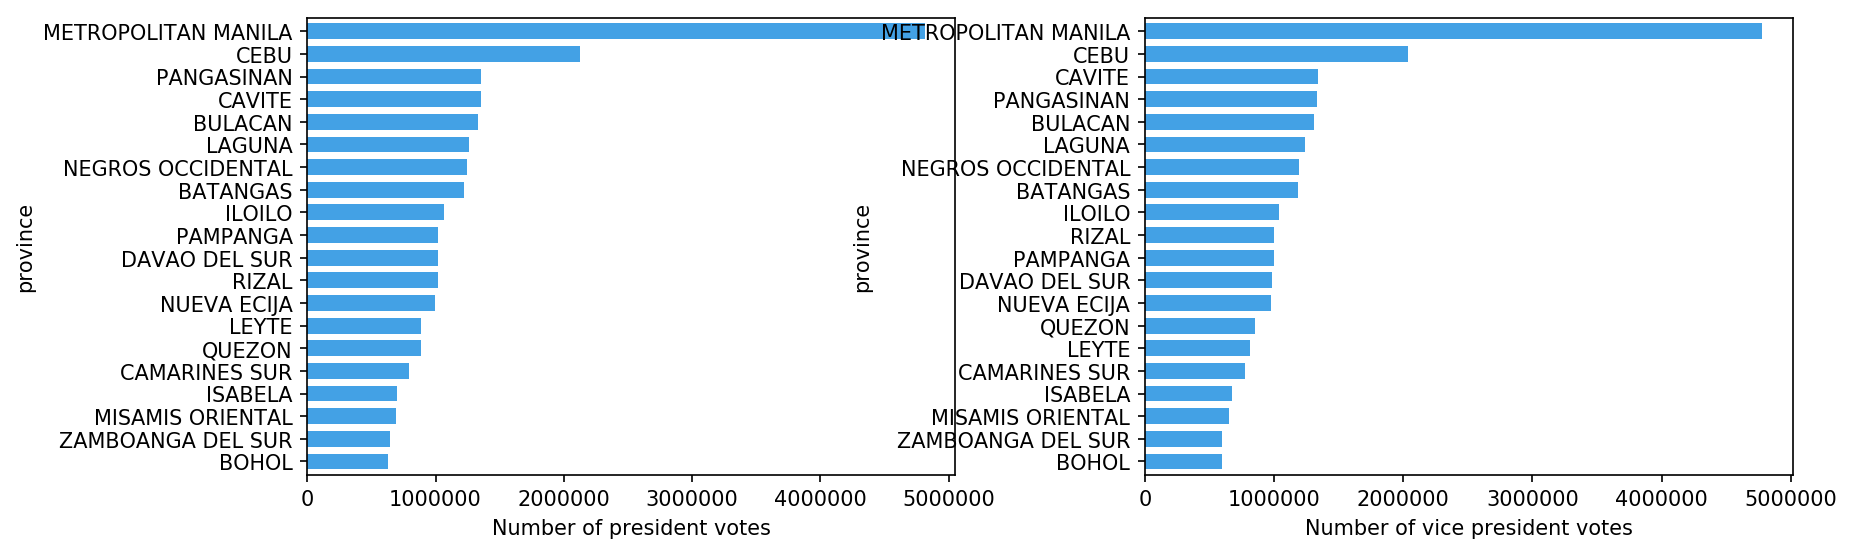

In [252]:
plot_dist_level(level='province')

#### Figure 4. Total presidential and vice-presidential votes obtained per province. The most vote-rich provinces are NCR, Cebu, Cavite, and Pangasinan.

<div><span style="background-color: #2b3237; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #43a1e5; font-size: 20px; font-weight: bold">REGIONALITY OF PRESIDENTIAL VOTING PREFERENCE </span></div>

In [260]:
def display_ranks(position='president', level='region'):
    """
    Displays the top candidate for each geographic unit. 
    
    position : president/vice-president
    level    : region/province
    """
    with open(f'Datasets/results_{position}_denormalized.pkl', 'rb') as f:
        df = pickle.load(f)
    df_ranking = df.groupby([level,'candidate_name']).agg({'votes': sum})
    df_ranking['rank'] = df_ranking.groupby(level)['votes'].rank(method='dense', ascending=False)
    df_ranking.reset_index(inplace=True)
    df_ranking_pivot = df_ranking.pivot(index='candidate_name', columns=level)['rank']
    
    label = {'president': "Presidential",
             'vice-president': "Vice-Presidential"}
    
    if level == 'region':
        fig, ax = plt.subplots(dpi=100, figsize=(8,3))
        sns.heatmap(df_ranking_pivot, ax=ax, cmap='Reds_r', square=True)
        ax.set_xlabel('Region')
        ax.set_ylabel('Candidate')
        ax.set_title(f'{label[position]} Ranking heatmap')
        plt.xticks(rotation=80);
    
    ph = gpd.GeoDataFrame.from_file(f"Datasets/ph_{level}s.shp")
    
    df_top = df_ranking[df_ranking['rank']==1.0]
    df_merged = ph.merge(df_top, left_on=level, right_on=level)
    color_map = {'DUTERTE, RODY (PDPLBN)': 'red',
                 'POE, GRACE (IND)': 'white', 
                 'ROXAS, MAR DAANG MATUWID (LP)': 'yellow', 
                 'BINAY, JOJO (UNA)': 'orange',
                 'ROBREDO, LENI DAANG MATUWID (LP)': 'yellow', 
                 'MARCOS, BONGBONG (IND)': 'green',
                 'CAYETANO, ALAN PETER (IND)': 'red',
                 'ESCUDERO, CHIZ (IND)': 'white'}

    fig, ax = plt.subplots(dpi=100, figsize=(8,10))
    ax.set_title(f'Top {label[position]} candidate per {level}');
    
    df_top.to_csv(f'Datasets/results_{position}_{level}_top.csv')
    
    for candidate in df_merged['candidate_name'].unique():
        df_merged[df_merged['candidate_name'] == candidate].plot(ax=ax, color = color_map[candidate], 
                                          categorical = True, legend=True)

    df_merged.geometry.boundary.plot(color=None,edgecolor='k',linewidth = .5,ax=ax);
    ax.axis('off');
    
    for ind, row in ph.iterrows():
        ax.text(row["geometry"].centroid.x, row["geometry"].centroid.y,
            row[level], fontsize=4);
    

**Insights:**
- Rody Duterte won in 11 out of the 19 regions. Both Mar Roxas and Grace Poe won in three regions each.
- From a regional perspective:
    - Duterte (red) won the entire Mindanao island, Central Luzon, CALABARZON, Central Luzon, and NCR. 
    - Mar Roxas (yellow) is particularly strong in the Visayas region, as he is from Capiz. Interesting that he was not able to capture Region 5, where his running mate Leni Robredo hails from.
    - Jejomar Binay (orange) captured the Cagayan Region votes, as his mother is from Isabela.
    - Grace Poe (white) captured the rest of Luzon, including the Ilocos Region, CAR, and Region 5. 

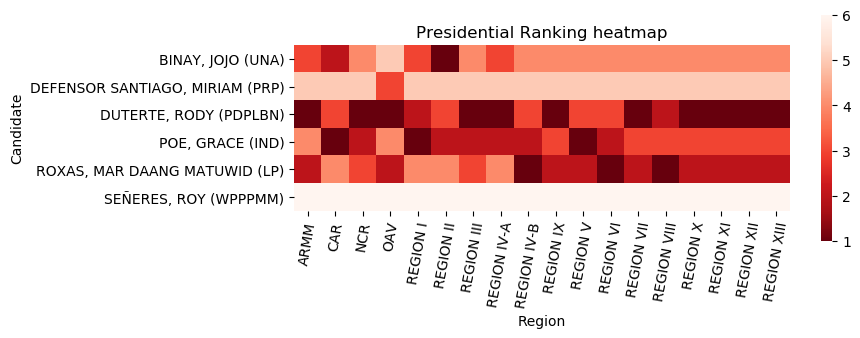

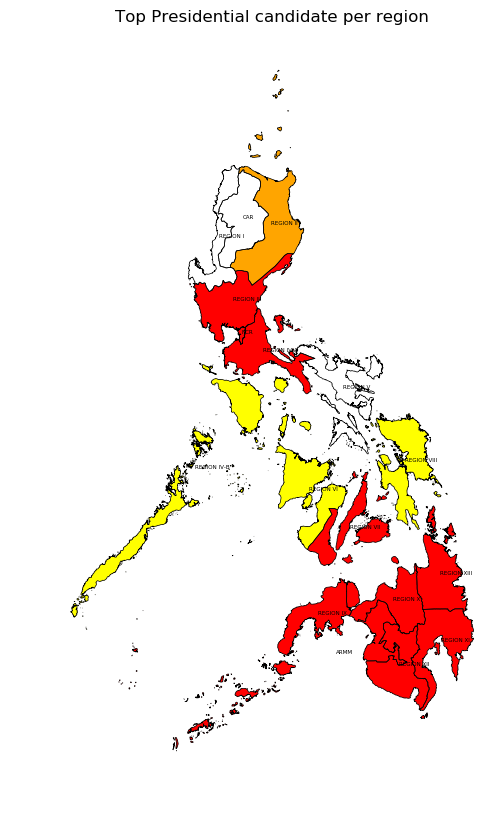

In [261]:
display_ranks('president', 'region')

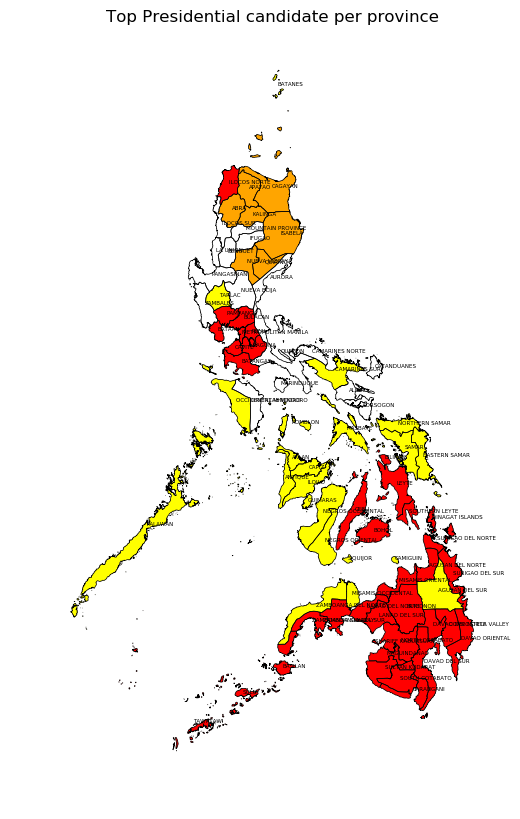

In [263]:
display_ranks('president', 'province')

<div><span style="background-color: #2b3237; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #43a1e5; font-size: 20px; font-weight: bold">REGIONALITY OF VICE PRESIDENTIAL VOTING PREFERENCE </span></div>

**Insights:**
- Robredo won in 9 regions, while Marcos won in 8 regions.
- From a regional perspective:
    - **North vs South**: Marcos (green) captured northern Luzon (Solid North), while Robredo (yellow) got Southern Luzon.
    - Robredo captured the entire Visayas region except for Leyte, where Imelda Marcos (Bongbong Marcos' mother) is from.
    - Cayetano (red) was able to get the support of Davao region, the home of his running mate Rodrigo Duterte. 

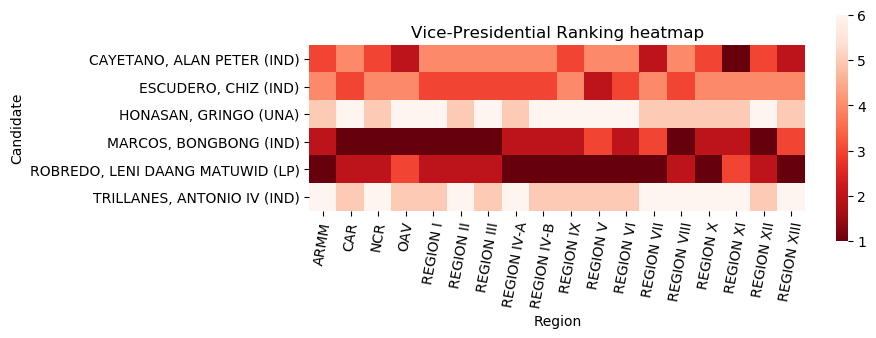

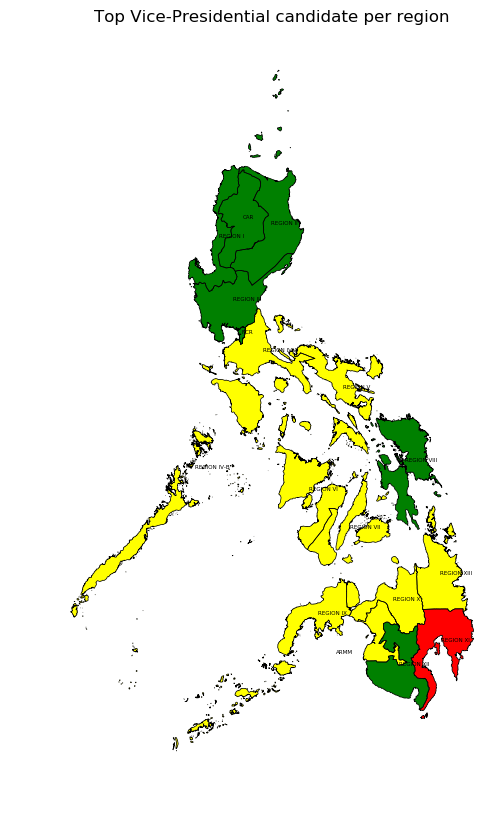

In [264]:
display_ranks('vice-president', 'region')

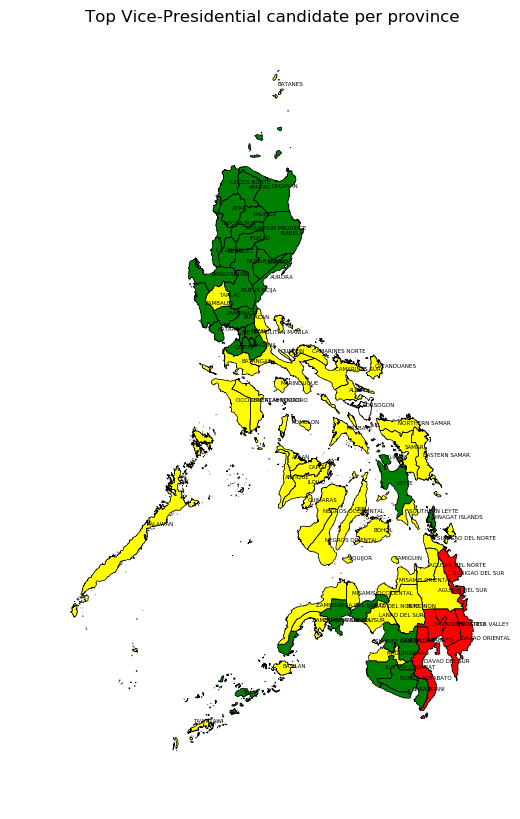

In [265]:
display_ranks('vice-president', 'province')

<div><span style="background-color: #2b3237; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #43a1e5; font-size: 20px; font-weight: bold">BLOC VOTING </span></div>

In [268]:
df_pres_top = pd.read_csv('Datasets/results_president_region_top.csv')

In [269]:
df_vp_top = pd.read_csv('Datasets/results_vice-president_region_top.csv')

In [273]:
df_top = pd.merge(df_pres_top, df_vp_top, on='region')

From the table below, only **MIMAROPA/Region IV-B** (Roxas-Robredo), **Eastern Visayas/Region VI** (Roxas-Robredo), and **Davao Region/Region XI** (Duterte-Cayetano) did block voting for the presidential and vice-presidential positions. For the rest of the country, the most common combinations are Duterte-Robredo (6 regions) and Duterte-Marcos (4 regions).

In [318]:
df_top[['region', 'candidate_name_x', 'candidate_name_y']].rename(columns={'candidate_name_x':'President', 'candidate_name_y': 'Vice President'})

,region,President,Vice President
0,ARMM,"DUTERTE, RODY (PDPLBN)","ROBREDO, LENI DAANG MATUWID (LP)"
1,CAR,"POE, GRACE (IND)","MARCOS, BONGBONG (IND)"
2,NCR,"DUTERTE, RODY (PDPLBN)","MARCOS, BONGBONG (IND)"
3,OAV,"DUTERTE, RODY (PDPLBN)","MARCOS, BONGBONG (IND)"
4,REGION I,"POE, GRACE (IND)","MARCOS, BONGBONG (IND)"
5,REGION II,"BINAY, JOJO (UNA)","MARCOS, BONGBONG (IND)"
6,REGION III,"DUTERTE, RODY (PDPLBN)","MARCOS, BONGBONG (IND)"
7,REGION IV-A,"DUTERTE, RODY (PDPLBN)","ROBREDO, LENI DAANG MATUWID (LP)"
8,REGION IV-B,"ROXAS, MAR DAANG MATUWID (LP)","ROBREDO, LENI DAANG MATUWID (LP)"
9,REGION IX,"DUTERTE, RODY (PDPLBN)","ROBREDO, LENI DAANG MATUWID (LP)"


In [285]:
df_top['Pair'] = df_top.apply(lambda x: x['candidate_name_x'] + ' and ' + x['candidate_name_y'], axis=1)

In [305]:
df_pairs = df_top.groupby('Pair')['region'].count().sort_values(ascending=True).to_frame()

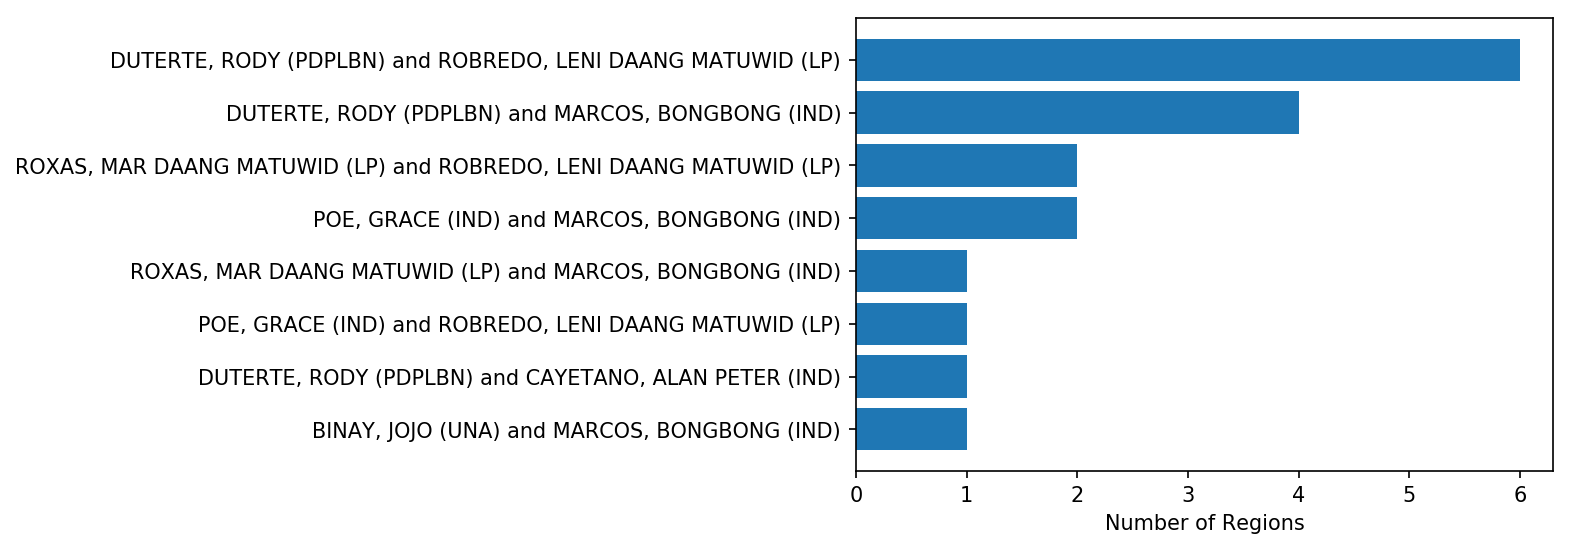

In [311]:
fig, ax = plt.subplots(dpi=150)
ax.barh(df_pairs.index, df_pairs['region'])
ax.set_xlabel('Number of Regions');

<div><span style="background-color: #2b3237; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #43a1e5; font-size: 20px; font-weight: bold">TABLEAU DASHBOARDS</span></div>

The following Tableau dashboards were created using the processed datasets:

1. [2016 Philippine Presidential Race](https://public.tableau.com/views/elections2016/Presidential?:retry=yes&:display_count=y&:origin=viz_share_link) - an interactive dashboard of the 2016 Philippine Presidential Election results
2. [2016 Philippine Vice Presidential Race](https://public.tableau.com/views/Halalan2016ThePhilippineVice-PresidentialRace/Vice-Presidential?:display_count=y&publish=yes&:origin=viz_share_link) - an interactive dashboard of the 2016 Philippine Vice Presidential Election results
2. [Why Leni Robredo Won?](https://public.tableau.com/views/WhyLeniRobredoWon/Story1?:display_count=y&publish=yes&:origin=viz_share_link) - a data story on how Leni Robredo won the vice presidency

<div><span style="background-color: #2b3237; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #43a1e5; font-size: 20px; font-weight: bold">CONCLUSIONS</span></div>

Voting preference is characterized by **high regionality**, as exhibited by Marcos claiming the Northern Luzon votes, Duterte getting the Mindanao votes, and Robredo winning in Bicol region. Candidates have a homecourt advantage, and voters tend to vote candidates or parties affiliated with their home region.